# Imports

In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
sys.path.append('/mnt/home/cmodi/.local/lib/python3.8/site-packages/')


In [4]:
import nbodykit
from nbodykit.cosmology import LinearPower, Cosmology, Planck15, HalofitPower
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.integrate import simps

import torch
from torch import nn

In [5]:
sys.path.append('../src/')
import pt
from utils import BoltzNet, loginterp
pklinfunc_nb = pt.NBPklin()

/mnt/home/cmodi/miniconda3/envs/ptorch/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:960: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.382196e-06
  warnings.warn(


In [6]:
## Compute $P_{22}$
from scipy.special import p_roots


In [7]:
import loader_pk
import sbitools, sbiplots

args = {"kmin": 0.01, "kmax":0.3, "offset_amp":0, "ampnorm":False}
args = sbitools.Objectify(args)
kcut, features, params = loader_pk.loader(args, return_k=True)


Loaded power spectrum data with shape :  (2000, 128)
pk shape after k-cuts :  (2000, 46)


# Compute linear power spectrum

In [509]:
def get_ps(Omega0_m, Omega0_b, h, ns, sigma_8):

    Omega0_cdm = Omega0_m - Omega0_b
    cosmo = Planck15.clone(Omega0_cdm=Omega0_cdm, Omega0_b=Omega0_b, h=h, n_s=ns, sigma_8=sigma_8)
    # print(cosmo.parameter_dict)
    k_arr = np.geomspace(1e-6,20,100)
    pklin = LinearPower(cosmo, 0.0, transfer='CLASS')
    pk_arr = pklin(k_arr)
    PkL = InterpolatedUnivariateSpline(k_arr,pk_arr,ext='zeros')
    return PkL


get_ps(0.3, 0.05, 0.67, 0.966, 0.8)

In [510]:
%timeit get_ps(0.3, 0.05, 0.67, 0.966, 0.8)

2.47 s ± 7.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [457]:
z = 0.
k_arr = np.geomspace(1e-6,10,100)
cosmo = Planck15
pklin = LinearPower(cosmo, 0.0)
pkhf = HalofitPower(cosmo, 0.0)
pk_arr = pklin(k_arr)
PkL = InterpolatedUnivariateSpline(k_arr,pk_arr,ext='zeros')


### Compute $P_{13}$
r_arr = np.geomspace(1e-5,9e4,1001)[None,:]
P13_pref = k_arr**3/(252.*(2.*np.pi)**2)*PkL(k_arr)
P13_integ = lambda r: 12./r**4.-158./r**2.+100.-42.*r**2+3./r**5.*(7.*r**2+2)*(r**2-1.)**3.*np.log(np.abs((r+1.)/(r-1.)))
P13_raw = P13_pref*simps(r_arr**2*PkL(r_arr*k_arr[:,None])*P13_integ(r_arr),r_arr)
P13 = InterpolatedUnivariateSpline(k_arr,P13_raw,ext='zeros')


## Compute $P_{22}$
mu_arr,w_arr = p_roots(100) # Gauss-Legendre quadrature weights
mu_arr = mu_arr[None,None,:]
w_arr = w_arr[None,None,:]
P22_pref = k_arr**3./(2.*np.pi**2)
psi_arr = np.sqrt(1.+r_arr[:,:,None]**2-2*r_arr[:,:,None]*mu_arr)
F_2d = lambda r, mu: (7.*mu+(3.-10.*mu**2)*r)/(14.*r*(r**2-2.*r*mu+1.))
mu_integral = np.sum(w_arr*PkL(k_arr[:,None,None]*psi_arr)*np.abs(F_2d(r_arr[:,:,None],mu_arr))**2.,axis=2)
P22_raw = P22_pref*simps(r_arr**2*PkL(r_arr*k_arr[:,None])*mu_integral,r_arr,axis=1)
P22 = InterpolatedUnivariateSpline(k_arr,P22_raw,ext='zeros')

## Compute counterterm
Pct = lambda k,cs: -2.*cs*k**2*PkL(k)

In [464]:
%%timeit 

# mu_arr,w_arr = p_roots(100) # Gauss-Legendre quadrature weights
# mu_arr = mu_arr[None,None,:]
# w_arr = w_arr[None,None,:]
# P22_pref = k_arr**3./(2.*np.pi**2)
# psi_arr = np.sqrt(1.+r_arr[:,:,None]**2-2*r_arr[:,:,None]*mu_arr)
# F_2d = lambda r, mu: (7.*mu+(3.-10.*mu**2)*r)/(14.*r*(r**2-2.*r*mu+1.))
mu_integral = np.sum(w_arr*PkL(k_arr[:,None,None]*psi_arr)*np.abs(F_2d(r_arr[:,:,None],mu_arr))**2.,axis=2)
# P22_raw = P22_pref*simps(r_arr**2*PkL(r_arr*k_arr[:,None])*mu_integral,r_arr,axis=1)
# P22 = InterpolatedUnivariateSpline(k_arr,P22_raw,ext='zeros')
P22(k)

403 ms ± 635 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [474]:
%timeit k_arr[:,None,None]*psi_arr

19.8 ms ± 274 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [475]:
%timeit PkL(ktmp) #*np.abs(F_2d(r_arr[:,:,None],mu_arr))**2.,axis=2)


324 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [466]:
%timeit np.sum(w_arr*PkL(k_arr[:,None,None]*psi_arr)*np.abs(F_2d(r_arr[:,:,None],mu_arr))**2.,axis=2)


404 ms ± 521 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
k_plot = np.geomspace(5e-3,0.1,1000)
def plot(spec,label,col):
    plt.plot(k_plot,spec(k_plot),label=label,c=col)
    plt.plot(k_plot,-spec(k_plot),c=col,ls='--')
plot(PkL,'Linear','r')
plot(P13,'13','b')
plot(P22,'22','g')
plot(lambda k: Pct(k, 1.0),'counterterm','yellow')
plot(lambda k: P22(k)+P13(k)+Pct(k,1.0),'1-Loop','purple')
plot(lambda k: PkL(k)+P22(k)+P13(k)+Pct(k,1.0),'Total','k')
plot(pkhf,'Halofit','grey')

plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12,ncol=3)
plt.xlabel(r'$k$ $[h/\mathrm{Mpc}]$',fontsize=12)
plt.ylabel(r'$P(k)$',fontsize=12)
plt.xlim(min(k_plot),max(k_plot))

(0.005, 0.1)

In [9]:
pkmatter = pt.PkMatter()

plt.plot(k_plot, abs(pkmatter.p13(PkL)(k_plot)), 'C0')
plt.plot(k_plot, abs(P13(k_plot)), 'C0--', lw=2)

plt.plot(k_plot, abs(pkmatter.p22(PkL)(k_plot)), 'C1')
plt.plot(k_plot, abs(P22(k_plot)), 'C1--', lw=2)

plt.plot(k_plot, abs(pkmatter.pct(PkL)(k_plot, 1)), 'C2')
plt.plot(k_plot, abs(Pct(k_plot, 1)), 'C2--', lw=2)

plt.loglog()

[]

# linear power spectra

[0.1821  0.04809 0.5865  0.9565  0.8101 ]


/mnt/home/cmodi/.local/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:832: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.110450e-06
  warnings.warn(


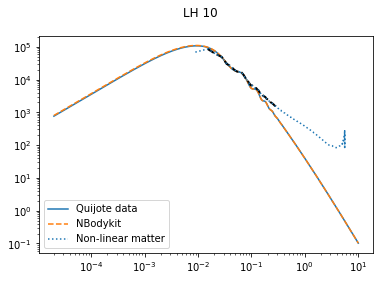

<Figure size 432x288 with 0 Axes>

In [13]:
i = 10
print(params[i])
pss = pklinfunc_nb(*list(params[i]))
klin, plin = np.loadtxt(f'/mnt/ceph/users/fvillaescusa/Quijote/Linear_Pk/latin_hypercube/{i}/Pk_mm_z=0.000.txt').T
normfac = loadtxt(f'/mnt/ceph/users/fvillaescusa/Quijote/Linear_Pk/latin_hypercube/{i}/Normfac.txt')
knlin, pknlin = np.loadtxt(f'/mnt/ceph/users/fvillaescusa/Quijote/Pk/matter/latin_hypercube/{i}/Pk_m_z=0.txt').T
plin *= normfac

plt.plot(klin, plin, 'C0', label='Quijote data')
plt.plot(klin, pss(klin), 'C1--', label='NBodykit')
plt.plot(kcut, features[i], 'k--', lw=2)
plt.plot(knlin, pknlin, 'C0:', label='Non-linear matter')

plt.loglog()
plt.legend()
plt.suptitle(f'LH {i}')
plt.show()
plt.tight_layout()

[]

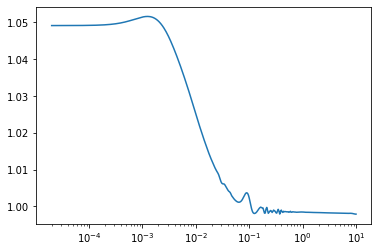

In [15]:
plt.plot(klin, pss(klin)/plin)
plt.semilogx()

# train MLP

In [ ]:
covpt = np.load('../data/cov_disconnected_cs1_quijote.npy')
kmatter = np.load('../data/kmatter_quijote.npy')

In [388]:
# params = np.load('/mnt/ceph/users/cmodi/Quijote/params_lh.npy')
# trainset_raw = np.load('../data/pklin_quijote_lextrap.npy')
# ktrain = np.load('../data/klin_quijote_lextrap.npy')
# trainset = np.load('../data/pklin_quijote_lextrap.npy')
# trainset = np.log(trainset)
# loc, scale = trainset.mean(axis=0), trainset.std(axis=0)
# trainset = (trainset - loc)/scale
# X = torch.from_numpy(params.astype(np.float32))
# Y = torch.from_numpy(trainset.astype(np.float32))

params = np.load('/mnt/ceph/users/cmodi/Quijote/params_lh.npy')
trainset_raw = np.load('../data/pklin_plus_1loop_quijote.npy')
# trainset_raw = np.load('../data/spt_spectra_quijote_lh.npz')['p_linear_plus_loop']
ktrain = np.load('../data/klin_quijote.npy')
i0 = np.where(ktrain >5e-3)[0][0]
i1 = np.where(ktrain >0.25)[0][0]+1
trainset_raw = trainset_raw[:, i0:i1]
ktrain = ktrain[i0:i1]
trainset = trainset_raw.copy()  #+ 1e4
# trainset = np.log(trainset)
loc, scale = trainset.mean(axis=0), trainset.std(axis=0)
trainset = (trainset - loc)/scale
X = torch.from_numpy(params.astype(np.float32))
Y = torch.from_numpy(trainset.astype(np.float32))

In [384]:
trainset.min()

-14.929469216203861

In [385]:
ktrain.size

120

In [386]:
np.where(trainset <0);

(-8.639506241904934, 11.240216757690188)

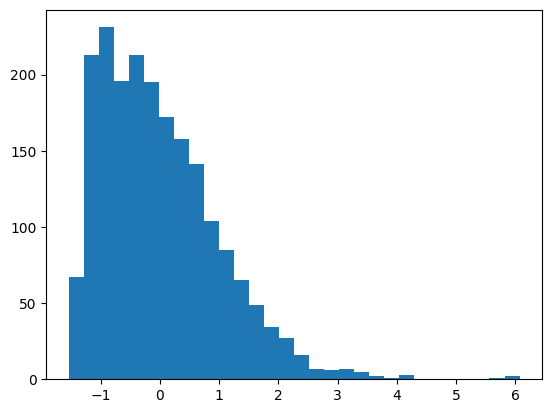

In [390]:
plt.hist(trainset[:, 100], bins=30);
trainset.min(), trainset.max()

## net 

In [391]:
ktrain.size

120

In [436]:
# model = BoltzNet(k=ktrain, d_in=5, d_out=500, nhidden=1000, loc=loc, scale=scale)
model = BoltzNet(k=ktrain, d_in=5, d_out=120, nhidden=500, loc=loc, scale=scale, log_it=False)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
losses = []


In [437]:
# niter = 20000
nepochs = 3000
batch = 40
for epoch in range(nepochs):
    idxp = np.random.permutation(np.arange(2000))
    if epoch 150 == 0: print(epoch)
    for n in range(2000//batch):
        idx = idxp[n*batch : (n+1)*batch]
        y_pred = model(X[idx])
        loss = loss_fn(y_pred, Y[idx])
        losses.append(loss.detach())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950


<bound method Optimizer.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 4.971239399803608e-05
    weight_decay: 0
)>


[]

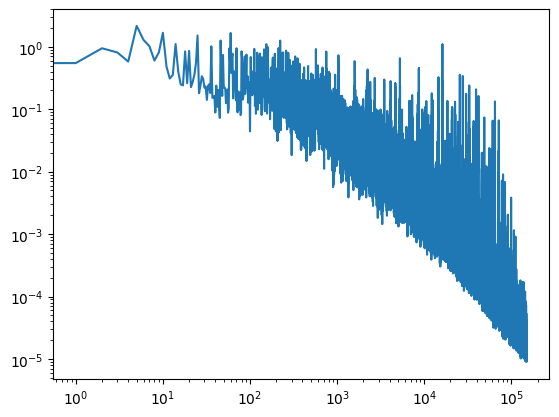

In [438]:
print(optimizer.state_dict)
plt.plot(losses)
plt.loglog()

In [449]:
# model.save_model('../data/sptnet/ep3k')
y_pred = model.predict(X)


2 [0.1867  0.04503 0.6189  0.8307  0.7187 ]


(0.95, 1.05)

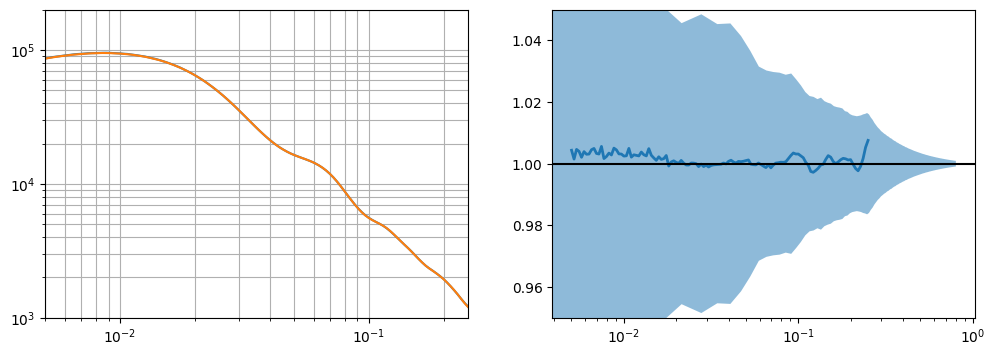

In [505]:
i = np.random.randint(0, 2000) 
i = 2
print(i, params[i])

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(ktrain, y_pred[i])
plt.plot(ktrain, trainset_raw[i])
plt.loglog()
plt.ylim(1e3, 2e5)
plt.xlim(5e-3, 0.25)
plt.grid(which='both')

plt.subplot(122)
plt.plot(ktrain, y_pred[i]/trainset_raw[i], lw=2)
plt.fill_between(kmatter, 1-covpt**0.5 /np.interp(kmatter, ktrain, trainset_raw[i]) \
         , 1+covpt**0.5 /np.interp(kmatter, ktrain, trainset_raw[i]), alpha=0.5)
plt.semilogx()
plt.axhline(1, color='k')
plt.ylim(0.95, 1.05)


max and min err :  0.19196681679648375 1.6386472509558103
0.0011458333333333333 0.009916666666666667
0.013658333333333333 0.03615
0.0551625 0.07214166666666667


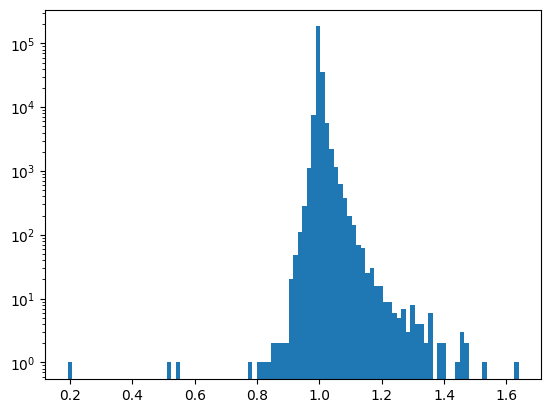

In [446]:
yratio = (y_pred/trainset_raw)
print('max and min err : ', yratio.min(), yratio.max())
# plt.hist((y_pred/trainset_raw).flatten(), bins='auto');
plt.hist((y_pred/trainset_raw).flatten(), bins=100);
plt.yscale('log')
print((yratio < 0.95).sum()/ yratio.size, (yratio > 1.05).sum()/ yratio.size)
print((yratio < 0.98).sum()/ yratio.size, (yratio > 1.02).sum()/ yratio.size)
print((yratio < 0.99).sum()/ yratio.size, (yratio > 1.01).sum()/ yratio.size)

In [447]:
ktrain[[20, 105]]

array([0.00968855, 0.15860806])

max and min err :  0.9055836090696607 1.1832029779901478
0.0004941176470588235 0.0005176470588235294
0.01358235294117647 0.004576470588235294
0.06365882352941177 0.0179


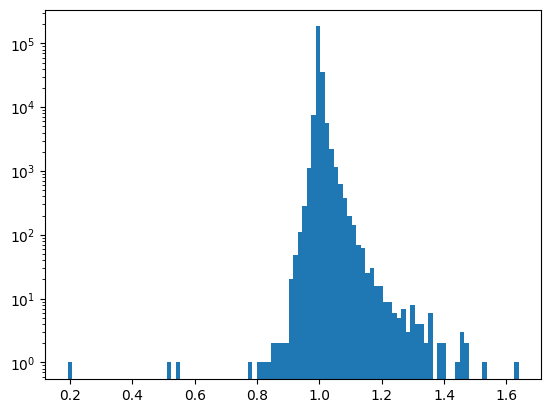

In [448]:
yratio = (y_pred/trainset_raw)[:, 20:105]
print('max and min err : ', yratio.min(), yratio.max())
# plt.hist((y_pred/trainset_raw).flatten(), bins='auto');
plt.hist((y_pred/trainset_raw).flatten(), bins=100);
plt.yscale('log')
print((yratio < 0.95).sum()/ yratio.size, (yratio > 1.05).sum()/ yratio.size)
print((yratio < 0.98).sum()/ yratio.size, (yratio > 1.02).sum()/ yratio.size)
print((yratio < 0.99).sum()/ yratio.size, (yratio > 1.01).sum()/ yratio.size)

## load model

In [490]:
pkqmatter = np.load('../data/pkmatter_quijote.npy')[..., 1]


Text(0.5, 0.98, 'LH0')

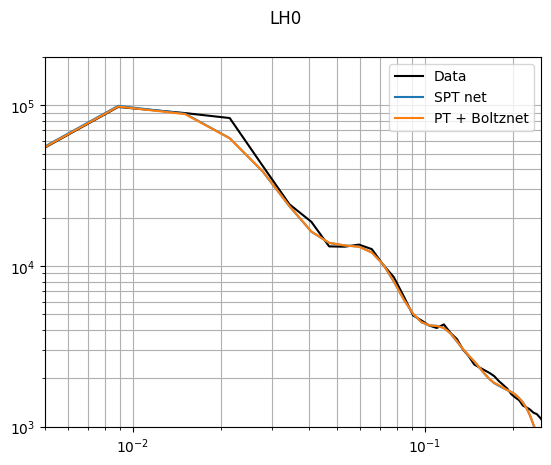

In [516]:
modelspt = BoltzNet(None, d_in=5, d_out=120, nhidden=500, log_it=False)
modelspt.load_model('../data/sptnet//ep3k/')

i = 0
cp = params[i]
plt.plot(kmatter, pkqmatter[i], 'k-', label='Data')
plt.plot(kmatter, modelspt.interp(cp)(kmatter), label='SPT net')
plt.plot(kmatter, pkmatter(kmatter, model.interp(cp), cs=0), label='PT + Boltznet')

plt.loglog()
plt.ylim(1e3, 2e5)
plt.xlim(5e-3, 0.25)
plt.grid(which='both')
plt.legend()
plt.suptitle(f'LH{i}')

In [510]:
ktrain = np.load('../data/klin_quijote_lextrap.npy')
model = BoltzNet(None, d_in=5, d_out=500, nhidden=1000)
model.load_model('../data/boltznet/ep3k/')
# y_pred = model.predict(X)


1257
[0.4565  0.06633 0.5605  1.0807  0.6323 ]


/mnt/home/cmodi/.local/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:832: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.780557e-06
  warnings.warn(


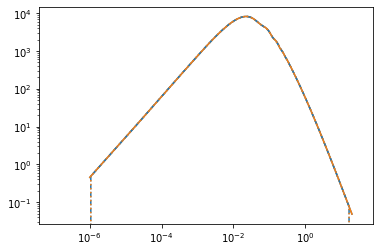

[]

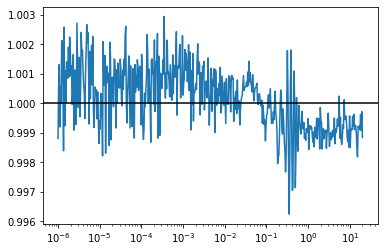

In [19]:
from scipy.optimize import curve_fit
line = lambda x, m, c : m*x + c


i = np.random.randint(2000)
# i = 330
print(i)
print(params[i])
    
pstrue = pklinfunc_nb(*params[i])
psq = InterpolatedUnivariateSpline(ktrain, trainset_raw[i], ext='zeros')
psnn = InterpolatedUnivariateSpline(ktrain, y_pred[i], ext='zeros')
# psnn = loginterp(ktrain, y_pred[i], lp=1, rp=-1);
# psq = loginterp(ktrain, trainset_raw[i], lp=1, rp=-1);
# psnn = loginterp(ktrain, y_pred[i], lp=2, rp=-2, fitline=True);
# psq = loginterp(ktrain, trainset_raw[i], lp=2, rp=-2, fitline=True);

# lp = 10
# rp = -10
# yy = y_pred[i].copy()
# ynew = yy.copy()
# m, c = curve_fit(line, ktrain[:lp], yy[:lp], )[0]
# ynew[:lp] = line(ktrain[:lp], m, c)
# m, c = curve_fit(line, ktrain[rp:], yy[rp:], )[0]
# ynew[rp:] = line(ktrain[rp:], m, c)
# psnn = loginterp(ktrain, ynew, lp=lp//2, rp=rp//2);

# yy = trainset_raw[i].copy()
# ynew = yy.copy()
# m, c = curve_fit(line, ktrain[:lp], yy[:lp], )[0]
# ynew[:lp] = line(ktrain[:lp], m, c)
# m, c = curve_fit(line, ktrain[rp:], yy[rp:], )[0]
# ynew[rp:] = line(ktrain[rp:], m, c)
# psq = loginterp(ktrain, ynew, lp=lp//2, rp=rp//2);


ktest = np.geomspace(1e-7, 30, 100)
# plt.plot(ktest, pstrue(ktest), 'k')
plt.plot(ktrain, y_pred[i], 'C0')
plt.plot(ktrain, trainset_raw[i], 'C1')
plt.plot(ktest, psnn(ktest), 'C0--')
plt.plot(ktest, psq(ktest), 'C1:')
plt.loglog()
plt.show()
plt.figure()
plt.plot(ktrain, y_pred[i]/trainset_raw[i])
plt.axhline(1, color='k')
plt.semilogx()

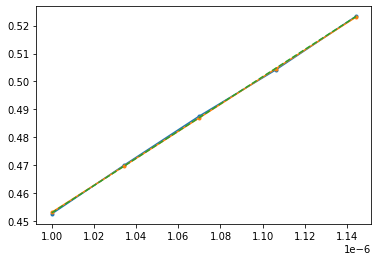

In [20]:
plt.plot(ktrain[:5], y_pred[i][:5], marker='.')
plt.plot(ktrain[:5], trainset_raw[i][:5], marker='.')
yy = y_pred[i].copy()
m, c = curve_fit(line, ktrain[:5], yy[:5], )[0]
plt.plot(ktrain[:5], line(ktrain[:5], m, c), '--')


[]

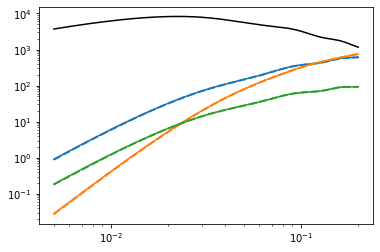

In [21]:
k_plot  = np.geomspace(5e-3, 0.2, 1000)
pkmatter = pt.PkMatter()

plt.plot(k_plot, abs((pstrue)(k_plot)), 'k')

plt.plot(k_plot, abs(pkmatter.p13(pstrue)(k_plot)), 'C0')
plt.plot(k_plot, abs(pkmatter.p13(psq)(k_plot)), 'C0:')
plt.plot(k_plot, abs(pkmatter.p13(psnn)(k_plot)), 'C0--', lw=2)

plt.plot(k_plot, abs(pkmatter.p22(pstrue)(k_plot)), 'C1')
plt.plot(k_plot, abs(pkmatter.p22(psq)(k_plot)), 'C1:')
plt.plot(k_plot, abs(pkmatter.p22(psnn)(k_plot)), 'C1--', lw=2)

plt.plot(k_plot, abs(pkmatter.pct(pstrue)(k_plot, 1)), 'C2')
plt.plot(k_plot, abs(pkmatter.pct(psq)(k_plot, 1)), 'C2:')
plt.plot(k_plot, abs(pkmatter.pct(psnn)(k_plot, 1)), 'C2--', lw=2)
# 
plt.loglog()

[]

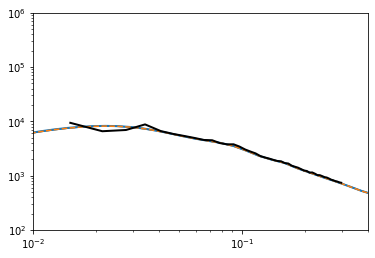

In [22]:
# plot(lambda k: PkL(k)+P22(k)+P13(k)+Pct(k,1.0),'Total','k')

k = np.logspace(-3, 0)
plt.plot(k, pstrue(k) + pkmatter.p13(pstrue)(k) + \
         pkmatter.p22(pstrue)(k) + \
          pkmatter.pct(pstrue)(k, 1), 'C0-', lw=2)
plt.plot(k, psq(k) + pkmatter.p13(psq)(k) + \
         pkmatter.p22(psq)(k) + \
          pkmatter.pct(psq)(k, 1))
plt.plot(k, psnn(k) + pkmatter.p13(psnn)(k) + \
         pkmatter.p22(psnn)(k) + \
          pkmatter.pct(psnn)(k, 1), '--')
plt.plot(kcut, features[i], 'k', lw=2)
plt.xlim(1e-2, 0.4)
plt.ylim(1e2, 1e6)
plt.loglog()


[]

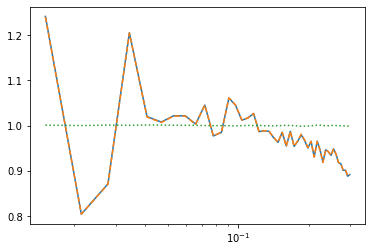

In [23]:
# plot(lambda k: PkL(k)+P22(k)+P13(k)+Pct(k,1.0),'Total','k')

k = kcut
plt.plot(k, features[i] / (psq(k) + pkmatter.p13(psq)(k) + \
         pkmatter.p22(psq)(k) + \
          pkmatter.pct(psq)(k, 0.1)))
plt.plot(k, features[i] / (psnn(k) + pkmatter.p13(psnn)(k) + \
         pkmatter.p22(psnn)(k) + \
          pkmatter.pct(psnn)(k, 0.1)), '--')
plt.plot(k, (psnn(k) + pkmatter.p13(psnn)(k) + \
         pkmatter.p22(psnn)(k) + \
          pkmatter.pct(psnn)(k, 0.1)) / (psq(k) + pkmatter.p13(psq)(k) + \
         pkmatter.p22(psq)(k) + \
          pkmatter.pct(psq)(k, 0.1)), ':')
# plt.plot(kcut, features[i])
plt.semilogx()


# Extrapolate Quijote power spectrum

In [92]:
del loginterp

In [93]:
from utils import loginterp

In [97]:
pklinq = np.load('../data/pklin_quijote.npy')
klinq = np.load('../data/klin_quijote.npy')
ksave = np.geomspace(1e-6, 20, 500)

646


[]

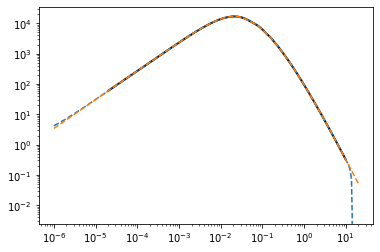

In [112]:
i = np.random.randint(2000)
print(i)
ilpk = loginterp(klinq, pklinq[i], verbose=False) 
plt.plot(klinq, pklinq[i], lw=2, color='k')
plt.plot(ksave, InterpolatedUnivariateSpline(klinq, pklinq[i])(ksave), '--')
plt.plot(ksave, ilpk(ksave), '--')
plt.loglog()

In [113]:
# pk_extrap = np.zeros((2000, ksave.size))

# for i in range(2000):
#     if i%100 == 0 : print(i)
#     pk_extrap[i] = loginterp(klinq, pklinq[i], verbose=False)(ksave)
    
# np.save('../data/pklin_quijote_lextrap.npy', pk_extrap)
# np.save('../data/klin_quijote_lextrap.npy', ksave)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


# Put it all together

In [254]:
ktrain = np.load('../data/klin_quijote_lextrap.npy')
model = BoltzNet(None, d_in=5, d_out=500, nhidden=1000)
model.load_model('../data/boltznet/ep3k/')
# y_pred = model.predict(X)

pkmatter = pt.PkMatter()
pklinfunc_nb = pt.NBPklin()

/mnt/home/cmodi/miniconda3/envs/ptorch/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:960: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.382196e-06
  warnings.warn(


In [257]:
import sbitools
prior = sbitools.sbi_prior(sbitools.quijote_params()[0], offset=0)


[0.1755  0.06681 0.7737  0.8849  0.6641 ]


/mnt/home/cmodi/miniconda3/envs/ptorch/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:960: AccuracyWarning: divmax (10) exceeded. Latest difference = 7.316195e-07
  warnings.warn(


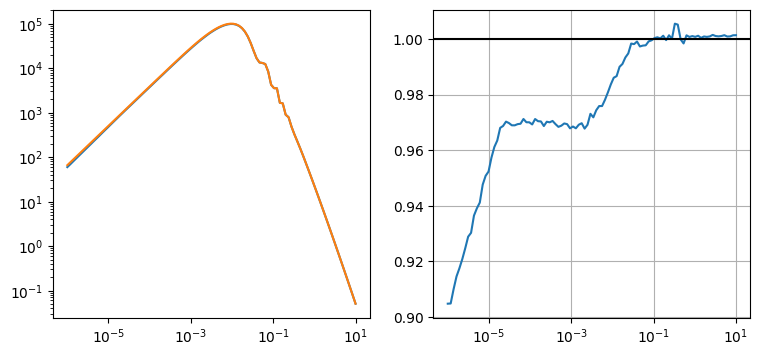

In [259]:
k_test = np.geomspace(1e-6, 10, 100)

i = 0
cp = prior.sample().numpy()
cp = params[i].copy()
# cp = np.array([0.19049197, 0.05769401, 0.6272516,  1.1218789,  0.6267067 ])
print(cp)

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.plot(k_test, model.interp(cp)(k_test))
# plt.plot(k_test, pklinfunc_nb(*cp)(k_test))
plt.plot(k_test, pklinfunc_nb(*cp)(k_test))
plt.loglog()

plt.subplot(122)
plt.plot(k_test, model.interp(cp)(k_test)/pklinfunc_nb(*cp)(k_test))
plt.semilogx()
plt.grid(which='both')
plt.axhline(1, color='k')

[0.41509518 0.03410598 0.6160346  1.1662028  0.8483374 ]


/mnt/home/cmodi/.local/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:832: AccuracyWarning: divmax (10) exceeded. Latest difference = 3.307898e-06
  warnings.warn(


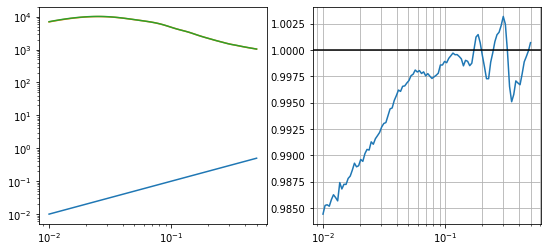

In [135]:
k_test = np.geomspace(1e-2, 0.5, 100)
cs = 1

cp = prior.sample().numpy()
print(cp)

pklnn = model.interp(cp)
pklnb = pklinfunc_nb(*cp)

pnn = pkmatter.interp(pklnn, cs)(k_test)
pnb = pkmatter.interp(pklnb, cs)(k_test)

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.plot(k_test, (k_test))
plt.plot(k_test, pnn)
plt.plot(k_test, pnb)
plt.loglog()

plt.subplot(122)
plt.plot(k_test, pnn/pnb)
plt.semilogx()
plt.grid(which='both')
plt.axhline(1, color='k')

In [219]:
f =  np.load('../data/spt_spectra_quijote_lh.npz')
f.files

['p_linear', 'p_linear_plus_loop']

In [221]:
f['p_linear'].shape

(2000, 400)

In [260]:
kqlin = np.load('../data/klin_quijote.npy');
pkqlin = np.load('../data/pklin_quijote.npy');

234 [0.2087  0.03575 0.5505  1.0617  0.8387 ]


/mnt/home/cmodi/miniconda3/envs/ptorch/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:960: AccuracyWarning: divmax (10) exceeded. Latest difference = 5.650211e-07
  warnings.warn(


Text(0.5, 0.98, 'LH 234')

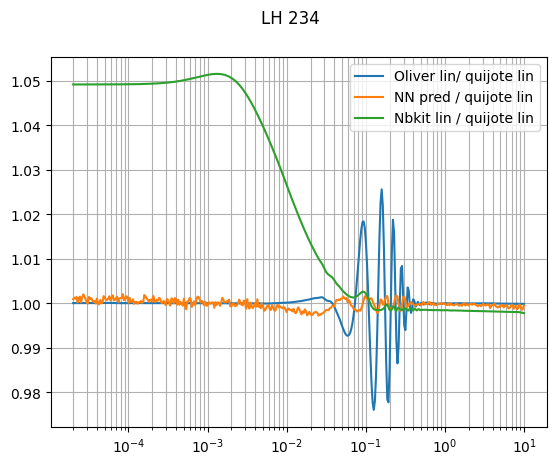

In [282]:
i = 234
cp = params[i]

print(i, cp)
plt.plot(kqlin, f['p_linear'][i]/ pkqlin[i], label='Oliver lin/ quijote lin')
plt.plot(kqlin, model.interp(cp)(kqlin)/ pkqlin[i], label='NN pred / quijote lin')
plt.plot(kqlin, pklinfunc_nb(*cp)(kqlin)/ pkqlin[i], label='Nbkit lin / quijote lin')
plt.legend()
plt.semilogx()
plt.grid(which='both')
plt.suptitle(f'LH {i}')

In [301]:
((kqlin > 5e-3) & (kqlin < 0.3)).sum()

125

In [302]:
# p1loops = []
# for i in range(2000):
#     if i%50 == 0 : print(i)
#     cp = params[i]
#     p1loop = pkmatter(kqlin, model.interp(cp), 0)
#     p1loops.append(p1loop)

# p1loops = np.array(p1loops)
# # np.save('../data/pklin_plus_1loop_quijote', p1loops)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950


500 [0.1923  0.05633 0.5003  1.0221  0.6813 ]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.9, 1.1)

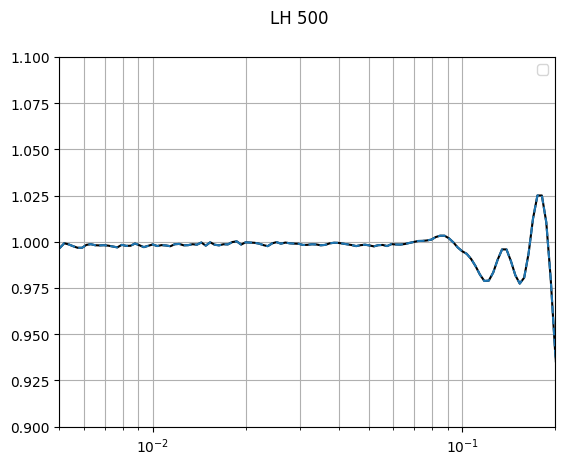

In [311]:
i = 500
cp = params[i]

print(i, cp)
# plt.plot(kqlin, f['p_linear_plus_loop'][i]/ pkqlin[i], label='Oliver lin/ quijote lin')
# plt.plot(kqlin, pkmatter(kqlin, model.interp(cp), 0)/ pkqlin[i], label='NN pred / quijote lin')
plt.plot(kqlin, pkmatter(kqlin, model.interp(cp), 0)/f['p_linear_plus_loop'][i], 'k')
plt.plot(kqlin, p1loops[i]/f['p_linear_plus_loop'][i], 'C0--')
# plt.plot(kqlin, pkmatter(kqlin, pklinfunc_nb(*cp), 0)/ pkqlin[i], label='Nbkit lin / quijote lin')
plt.legend()
plt.semilogx()
plt.grid(which='both')
plt.suptitle(f'LH {i}')
plt.xlim(5e-3, 0.2)
plt.ylim(0.9, 1.1)

# Covariance of Quijote

In [603]:
from nbodykit.lab import FFTPower, ArrayMesh


(1e-06, 20)

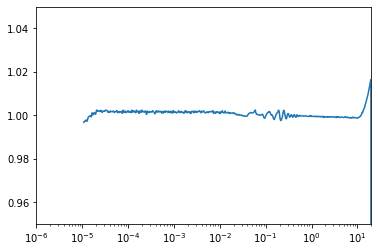

In [604]:
klinf, plinf = np.loadtxt(f'/mnt/ceph/users/fvillaescusa/Quijote/Linear_Pk/fiducial/CAMB_TABLES/CAMB_matterpow_0.dat').T
normfac = np.loadtxt(f'/mnt/ceph/users/fvillaescusa/Quijote/Linear_Pk/fiducial/Normfac.txt')
plinf *= normfac
cp = sbitools.quijote_params()[1]

# plt.plot(klinf, plinf)
# plt.plot(klinf, model.interp(cp)(klinf), '--')
# plt.loglog()

plt.plot(klinf, model.interp(cp)(klinf)/plinf)
plt.semilogx()
plt.ylim(0.95, 1.05)
plt.xlim(1e-6, 20)

In [605]:

box = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/0000/field.npy')
pk2 = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/0000/power.npy')
mesh = ArrayMesh(box/box.mean(), BoxSize=1000)
# pk = FFTPower(mesh, mode='1d', dk=2*np.pi/1000, kmin=2*np.pi/1000*fac ).power
pk = FFTPower(mesh, mode='1d').power
nmodes = pk['modes']
k = pk['k']
# np.save('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/nmodes.npy', nmodes)

field: ArrayMesh() painting done


/tmp/ipykernel_2102810/4033892044.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(nmodes/(4*pi*k**2 *np.diff(k)[2])*(2*pi)**3 )


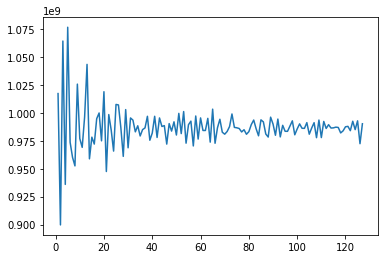

In [606]:
plt.plot(nmodes/(4*pi*k**2 *np.diff(k)[2])*(2*pi)**3 )
# plt.plot(nmodes)


In [607]:
pfids = []
for j in range(100):
    if j%100 ==0 : print(j)
    pfids.append(np.loadtxt(f'/mnt/ceph/users/fvillaescusa/Quijote/Pk/matter/fiducial_HR/{j}/Pk_m_z=0.txt')[:, 1])
pfids = np.array(pfids)
kfid = np.loadtxt(f'/mnt/ceph/users/fvillaescusa/Quijote/Pk/matter/fiducial_HR/0/Pk_m_z=0.txt')[:, 0]


0


In [608]:
cp = sbitools.quijote_params()[1]
# cov = 2*(pkmatter.interp(model.interp(cp), 1)(k))**2/nmodes
cov = 2*(pkmatter.interp(pklinfunc_nb(*cp), 1)(k))**2/nmodes


/mnt/home/cmodi/.local/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:832: AccuracyWarning: divmax (10) exceeded. Latest difference = 4.312526e-07
  warnings.warn(


In [619]:
np.stack([k, cov]).T.shape

(128, 2)

/mnt/home/cmodi/.local/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:832: AccuracyWarning: divmax (10) exceeded. Latest difference = 4.312526e-07
  warnings.warn(


[]

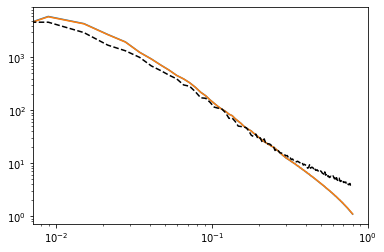

In [620]:
pkmatter = pt.PkMatter()
cp = sbitools.quijote_params()[1]
# cov0 = 2*(pkmatter.interp(model.interp(cp), 1)(k))**2/nmodes
cov = 2*(pkmatter.interp(pklinfunc_nb(*cp), 1)(k))**2/nmodes

# np.save('../data/cov_disconnected_cs1_quijote.npy', np.stack([k, cov]).T)
cov2 = pfids.std(axis=0)[:k.size]**2


plt.plot(k, cov**0.5)
plt.plot(k, cov0**0.5)
plt.plot(k, cov2**0.5, 'k--')
plt.loglog()

In [625]:
np.load(f'../data//pkmatter_quijote.npy')[0] #. reshape(1, -1)


array([[0.00000000e+00, 0.00000000e+00],
       [8.89964122e-03, 9.78135376e+04],
       [1.50791222e-02, 8.96191058e+04],
       [2.14479019e-02, 8.34522040e+04],
       [2.78366078e-02, 4.19911394e+04],
       [3.43509979e-02, 2.42410957e+04],
       [4.08399081e-02, 1.88531005e+04],
       [4.69870250e-02, 1.32556327e+04],
       [5.30822510e-02, 1.32016687e+04],
       [5.94536244e-02, 1.35985092e+04],
       [6.57769965e-02, 1.27471323e+04],
       [7.19768894e-02, 1.01792762e+04],
       [7.82786092e-02, 8.52093196e+03],
       [8.47767468e-02, 6.43864596e+03],
       [9.11413974e-02, 4.92639116e+03],
       [9.72930953e-02, 4.58616978e+03],
       [1.03531902e-01, 4.26061842e+03],
       [1.09800238e-01, 4.11625174e+03],
       [1.16138381e-01, 4.33222816e+03],
       [1.22436625e-01, 3.82945170e+03],
       [1.28791882e-01, 3.50710891e+03],
       [1.35052710e-01, 3.01759494e+03],
       [1.41247281e-01, 2.74696906e+03],
       [1.47554989e-01, 2.43933209e+03],
       [1.537865

/mnt/home/cmodi/.local/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:832: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.110450e-06
  warnings.warn(
Sampling progress :   5%|████████████▊                                                                                                                                                                                                                                                    | 10/200 [20:47<6:35:00, 124.74s/it]


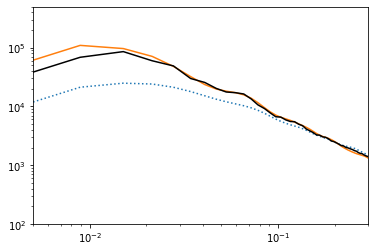

/tmp/ipykernel_2102810/3157560587.py:20: RuntimeWarning: invalid value encountered in divide
  plt.plot(k, pk/pth)
/tmp/ipykernel_2102810/3157560587.py:21: RuntimeWarning: invalid value encountered in divide
  plt.fill_between(k, 1-1*cov**0.5/pth, 1+1*cov**0.5/pth, alpha=0.5)
/tmp/ipykernel_2102810/3157560587.py:22: RuntimeWarning: divide by zero encountered in divide
  plt.fill_between(k, 1-1*cov2**0.5/pth, 1+1*cov2**0.5/pth, alpha=0.5)


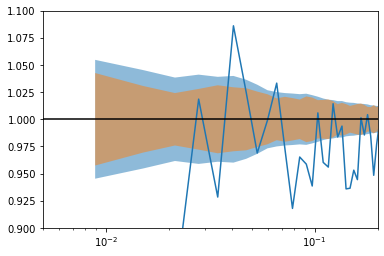

In [517]:

i = 10
cp = params[i]
k, pk = np.load(f'/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/{i:04d}/power.npy').T
# pth = pkmatter.interp(model.interp(cp), 1)(k)
pth = pkmatter.interp(pklinfunc_nb(*cp), 1)(k)

cp0 = sbitools.quijote_params()[1]

#plot spectra         
plt.plot(k, pkmatter.interp(model.interp(cp0), 1)(k), ':', label='fid')
plt.plot(k, pth)
plt.plot(k, pk, 'k')
plt.xlim(5e-3, 0.3)
plt.ylim(100, 5e5)

plt.loglog()
plt.show()
         
#compare with covariance
plt.plot(k, pk/pth)
plt.fill_between(k, 1-1*cov**0.5/pth, 1+1*cov**0.5/pth, alpha=0.5)
plt.fill_between(k, 1-1*cov2**0.5/pth, 1+1*cov2**0.5/pth, alpha=0.5)
plt.semilogx()
plt.xlim(5e-3, 0.2)
plt.ylim(0.9, 1.1)
plt.axhline(1, color='k')


[]

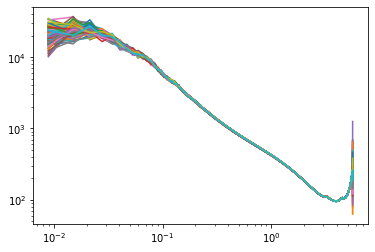

In [285]:
plt.plot(kfid, pfids.T)
plt.loglog()

In [306]:
# kfid[:k.size]/ k
pfids.std(axis=0)[:k.size]/cov**0.5

/tmp/ipykernel_2102810/4176978874.py:2: RuntimeWarning: divide by zero encountered in divide
  pfids.std(axis=0)[:k.size]/cov**0.5


array([       inf, 0.78951545, 0.68351478, 0.63299488, 0.6837226 ,
       0.80459529, 0.74064904, 0.78660418, 0.80246296, 0.86209207,
       0.76975083, 0.85744454, 0.82514151, 0.78694952, 0.89495544,
       0.90243739, 0.84769339, 0.93308302, 1.01153594, 0.9420732 ,
       0.83360185, 0.90025659, 0.88853918, 0.80720587, 0.87340465,
       0.96551766, 1.01206307, 0.93921852, 0.83104497, 0.86369785,
       1.01652469, 0.91002463, 1.03331746, 0.91851505, 1.12692348,
       0.94072787, 1.01683535, 1.04534768, 1.0288248 , 1.04572592,
       0.90885524, 1.03474603, 1.00896311, 0.99793649, 1.04053642,
       1.06933178, 1.08798243, 1.08728064, 1.14443073, 1.07587198,
       1.14355537, 1.08905631, 1.1461883 , 1.1039413 , 1.12535794,
       1.14401063, 1.22297061, 1.21224046, 1.23593791, 1.23809532,
       1.33378207, 1.23385497, 1.31814567, 1.33006112, 1.35372436,
       1.24845557, 1.30319496, 1.5356557 , 1.37086896, 1.47231102,
       1.50544787, 1.48775859, 1.39195861, 1.53707986, 1.50825

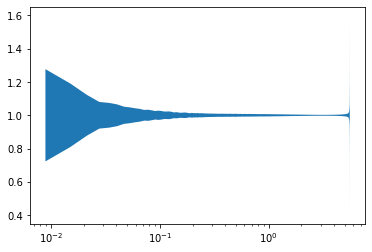

In [290]:
plt.fill_between(kfid, 1-pfids.std(axis=0)/pfids.mean(axis=0), 1+pfids.std(axis=0)/pfids.mean(axis=0))
plt.xscale('log')

# 1 loop

In [537]:
pquijote = np.load('../data/pkmatter_quijote.npy')

/mnt/home/cmodi/.local/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:832: AccuracyWarning: divmax (10) exceeded. Latest difference = 7.316195e-07
  warnings.warn(


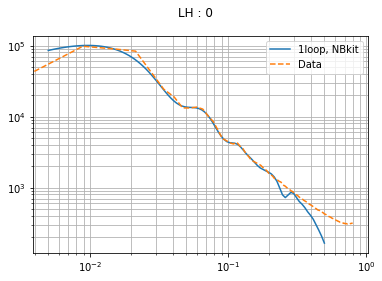

In [550]:
k1loop = np.geomspace(5e-3, 0.5, 100) 

i = 0 
cp = params[i]
pklin = pklinfunc_nb(*cp)
# plt.plot(k1loop, pkmatter(k1loop, pklin, 0.))
# pklin = model.interp(cp)
plt.plot(k1loop, pkmatter(k1loop, pklin, 0.), '-', label='1loop, NBkit')
plt.plot(pquijote[i, :, 0], pquijote[i, :, 1], '--',  label='Data')
plt.loglog()
plt.suptitle(f'LH : {i}')
plt.legend()
plt.grid(which='both')

# inference

In [8]:
import pt, utils
from utils import BoltzNet

In [13]:
import arviz as az

In [9]:
import zeus

In [19]:
import loader_pk
import sbitools, sbiplots

args = {"kmin": 0.001, "kmax":0.15, "offset_amp":0, "ampnorm":False}
args = sbitools.Objectify(args)
kcut, features, params = loader_pk.loader(args, return_k=True)


Loaded power spectrum data with shape :  (2000, 128)
pk shape after k-cuts :  (2000, 23)


In [20]:
# load PT objects
pklinfunc_nb = pt.NBPklin()
pkmatter = pt.PkMatter()


In [634]:
# load NN model
ktrain = np.load('../data/klin_quijote_lextrap.npy')
model = BoltzNet(None, d_in=5, d_out=500, nhidden=1000)
model.load_model('../data/boltznet/ep3k/')

modelspt = BoltzNet(None, d_in=5, d_out=120, nhidden=500, log_it=False)
modelspt.load_model('../data/sptnet//ep3k/')

In [ ]:
# def ppred():
#         pklin = model.interp(cp)
#         pct = pkmatter.pct(pklin)(kdata, cs)
#         p1loop = modelspt.interp(cp)(kdata)
#         pred = p1loop + pct
#         chisq = (pred - data)**2/cov
#         lk = -0.5 * np.sum(chisq)

In [650]:
cs = np.arange(4)*1.+0.1

In [651]:
# model.predict(params[0:4])
np.array(list(map(lambda f: f(kcut), modelspt.interp(params[0:4])))).shape

(4, 23)

In [652]:
np.array(list(map(lambda p: pkmatter.pct(p[0])(kdata, p[1]), zip(model.interp(params[0:4]), cs) )))

array([[  -1.56173095,   -4.02841023,   -5.75933236,   -5.99502902,
          -5.45750014,   -5.2556001 ,   -5.90364766,   -7.37667392,
          -9.23502818,  -10.43537828,  -10.29680419,   -9.02099067,
          -7.44919695,   -6.5355547 ,   -6.58589108,   -7.54450624,
          -9.04605076,  -10.37865751,  -10.79216481,  -10.08398762,
          -8.75252069,   -7.52499715,   -6.88027148],
       [  -8.0268314 ,  -25.01207125,  -43.86156393,  -57.29593449,
         -65.81752108,  -74.14944547,  -86.02972773, -102.26326592,
        -120.62948663, -134.47841897, -139.48392521, -136.55793288,
        -130.70288431, -128.09721824, -132.54781715, -143.99231447,
        -158.8727712 , -171.5087007 , -176.82541618, -173.69299518,
        -165.56788079, -157.71568209, -154.2536935 ],
       [ -31.59764449,  -78.4061708 , -115.91547662, -132.19124177,
        -135.73521447, -141.12758443, -156.57666061, -182.09951164,
        -211.72525829, -231.75843179, -234.02478517, -220.37139416,
        

In [631]:
list(map(model.interp, params[0:2]))

In [22]:
# import json
# with open('../data/boltznet/ep3k/params.json', 'w', encoding='utf-8') as f:
#     json.dump(model.input_params, f, ensure_ascii=False, indent=4)
# with open('../data/sptnet/ep3k/params.json', 'w', encoding='utf-8') as f:
#     json.dump(modelspt.input_params, f, ensure_ascii=False, indent=4)


[0.3133  0.06231 0.5619  0.9675  0.9093 ]


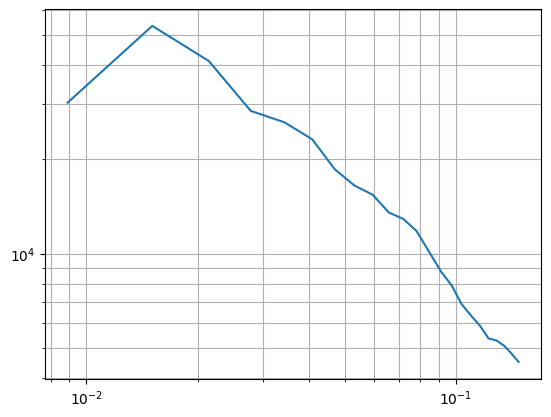

In [69]:
isim = 100
truep = params[isim]
print(truep)
data = features[isim].copy()
kdata = np.load('../data/kmatter_quijote.npy')[1:data.size+1]
cov = np.load('../data/cov_disconnected_cs1_quijote.npy')[1:data.size+1]
plt.plot(kdata, data)
plt.loglog()
plt.grid(which='both')

In [70]:
# priors = [torch.distributions.Uniform(model.lower_bounds[i], model.upper_bounds[i]) for i in range(5)]
# priors = priors + [torch.distributions.Uniform(-5, 5)]
priors = (list(model.lower_bounds) + [-5], list(model.upper_bounds) + [5])

# def log_prob(x, data, kdata, cov):
#     cp, cs = x[:-1], x[-1]
#     try:
#         pklin = model.interp(cp)
#         pred = pkmatter(kdata, pklin, cs)
#         chisq = (pred - data)**2/cov
#         lk = -0.5 * np.sum(chisq)
#         #prior
#         xtorch = torch.from_numpy(x)
#         lpr = sum([priors[i].log_prob(xtorch[i]) for i in range(6)])
#         lp = lpr + lk
#     except Exception as e:
#         print(e)
#         lp = -np.inf
#     return lp

def log_prob2(x, data, kdata, cov):
    cp, cs = x[:-1], x[-1]
    try:
        pklin = model.interp(cp)
        pct = pkmatter.pct(pklin)(kdata, cs)
        p1loop = modelspt.interp(cp)(kdata)
        pred = p1loop + pct
        chisq = (pred - data)**2/cov
        lk = -0.5 * np.sum(chisq)
        #prior
        lb = (x < priors[0]).sum()
        ub = (x > priors[1]).sum()
        if lb+ub:
            lpr = -np.inf
        else:
            lpr = 0 
        lp = lpr + lk
    except Exception as e:
        print(e)
        lp = -np.inf
    return lp


In [720]:
ndim = 6
nwalkers = 20

np.random.seed(42)
x0 = []
for i in range(ndim):
    if i < ndim-1: x0.append(np.random.uniform(model.lower_bounds[i], model.upper_bounds[i], nwalkers))
    else: x0.append(np.random.normal(0, 1, nwalkers))
x0 = np.array(x0).T
x0 = x0[0]
print(x0)

log_prob(x0, data, kdata, cov)

[0.24981605 0.05447412 0.54881529 0.95547092 0.94524137 0.08704707]
'list' object has no attribute 'log_prob'


-inf

In [721]:
log_prob2(x0, data, kdata, cov)

0 0


-1986.009803002344

In [654]:
%timeit log_prob(x0, data, kdata, cov)

328 ms ± 479 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [725]:
%timeit log_prob2(x0, data, kdata, cov)

1.56 ms ± 6.56 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### chain

In [76]:
nsteps, nwalkers, ndim = 1000, 20, 6

np.random.seed(42)
x0 = []
for i in range(ndim):
    if i < ndim-1: x0.append(np.random.uniform(model.lower_bounds[i], model.upper_bounds[i], nwalkers))
    else: x0.append(np.random.normal(0, 1, nwalkers))
x0 = np.array(x0).T



In [77]:
import emcee

In [78]:
start = time.time()
sampler = zeus.EnsembleSampler(nwalkers, ndim, log_prob2, args=[data, kdata, cov])
sampler.run_mcmc(x0, nsteps)
chain = sampler.get_chain(flat=False, thin=5)
print("Time taken : ", time.time() - start)


Initialising ensemble of 20 walkers...
Sampling progress : 100%|██████████| 1000/1000 [04:26<00:00,  3.75it/s]

Time taken :  266.8868124485016


In [102]:
az.convert_to_dataset(chain.transpose(1, 0, 2))
# az.ess(chain.transpose(1, 0, 2));


<xarray.Dataset>
Dimensions:  (chain: 20, draw: 200, x_dim_0: 6)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 192 193 194 195 196 197 198 199
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5
Data variables:
    x        (chain, draw, x_dim_0) float64 0.3022 0.05005 ... 0.8864 1.904
Attributes:
    created_at:     2023-07-15T22:29:39.443124
    arviz_version:  0.15.1

In [112]:
# 5000*20

100000

In [111]:
sum((list(map(az.ess, chain[..., 0].T))))

782.9892116625848

In [93]:
for i in range(nwalkers):
    print(az.ess(chain[:, i, 0]))

57.861943321895
58.14062834960514
32.949452301723305
31.668492645448204
47.71461721747602
47.85211218335481
56.48433530758042
1.3467701698441101
74.61260217469804
56.00266482580179
23.617024573392936
12.250260087402781
42.81466726913322
17.604889862386273
43.279010478016964
40.185784148910315
6.826063176344333
66.05353130677257
29.210015693671124
36.51434656912748


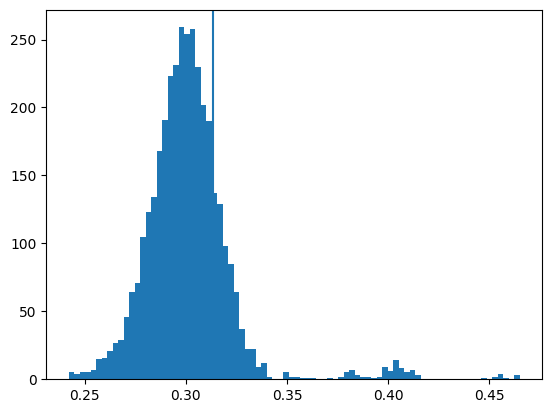

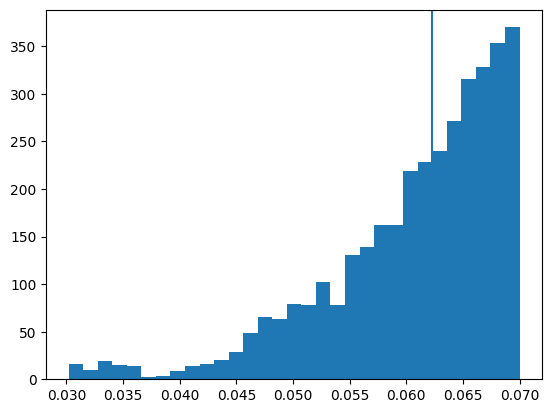

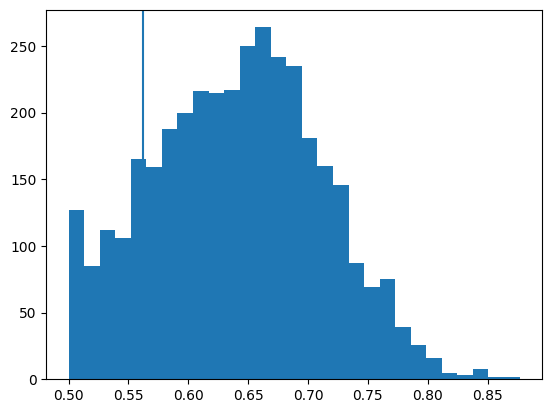

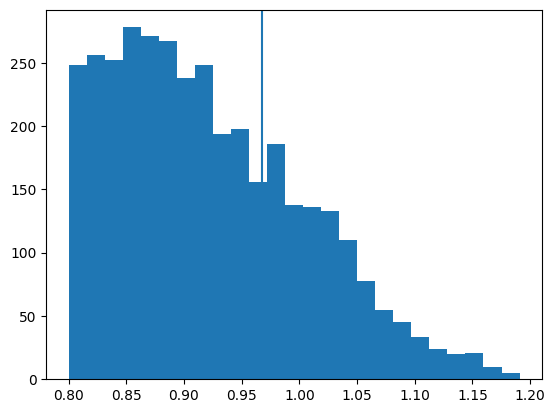

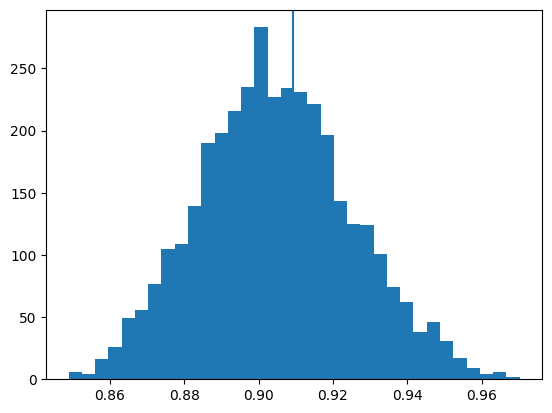

In [87]:
for i in range(5):
    plt.hist(chain[20:,..., i].flatten(), bins='auto')
    plt.axvline(truep[i])
    plt.show()

In [ ]:
start = time.time()
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_prob2, args=[data, kdata, cov])
sampler2.run_mcmc(x0, nsteps)
chain2 = sampler2.get_chain(flat=False)
print("Time taken : ", time.time() - start)


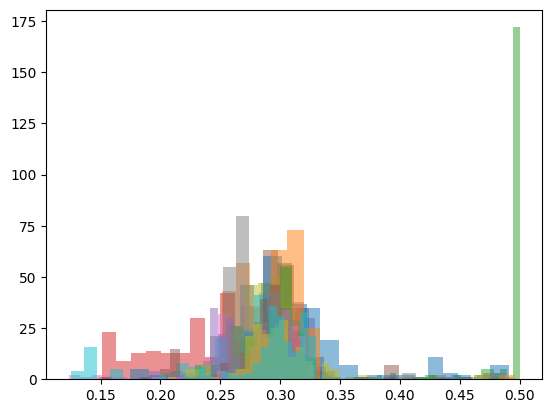

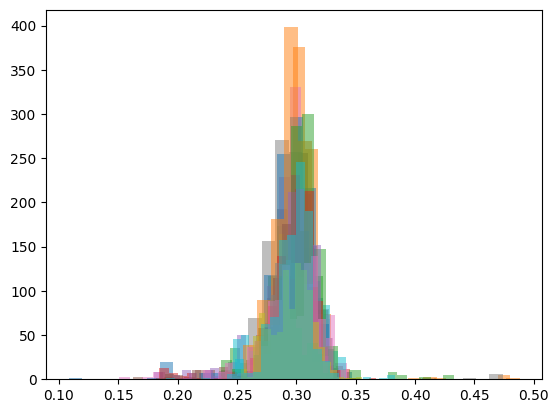

In [729]:
idim = 0
for i in range(20):    
    plt.hist(chain[:, i, idim], bins=20, alpha=0.5)

plt.show()
idim = 0
for i in range(20):    
    plt.hist(chain2[:, i, idim], bins=20, alpha=0.5)
plt.show()

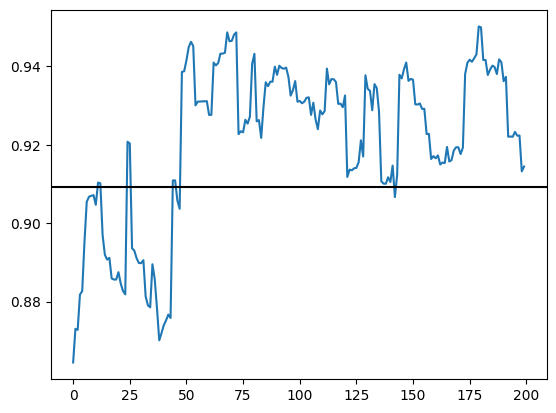

In [730]:
idim = 4
for i in range(1, 2):
    plt.plot(chain[:, i, idim])
plt.axhline(truep[idim], color='k')

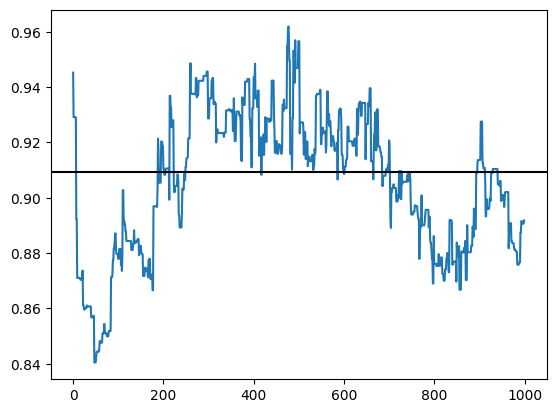

In [732]:
idim = 4 
# for i in range(nwalkers):
for i in range(0, 1):
    plt.plot(chain2[:, i, idim])
plt.axhline(truep[idim], color='k')



In [735]:
# %pip install arviz

     |████████████████████████████████| 1.6 MB 92.9 MB/s eta 0:00:01
     |████████████████████████████████| 973 kB 115.8 MB/s eta 0:00:01
     |████████████████████████████████| 804 kB 112.6 MB/s eta 0:00:01
     |████████████████████████████████| 502 kB 113.4 MB/s eta 0:00:01
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.5.0
    Uninstalling setuptools-59.5.0:
      Successfully uninstalled setuptools-59.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
zeus-mcmc 2.5.4 requires scikit-learn, which is not installed.
zeus-mcmc 2.5.4 requires seaborn, which is not installed.
wandb 0.13.7 requires protobuf!=4.21.0,<5,>=3.12.0; python_version < "3.9" and sys_platform == "linux", which is not installed.
wandb 0.13.7 requires requests<3,>=2.0.0, which is not installed.
tensorboard 2.11.0 requires absl-py>=0.4, which is not insta

In [30]:
cm = np.load('/mnt/home/cmodi/Research/Projects/HySBI/scripts/emcee_chain_LH100_kmax0.15.npy')
cz = np.load('/mnt/home/cmodi/Research/Projects/HySBI/scripts/zeus_chain_LH100_kmax0.15.npy')

In [31]:
cm.shape, cz.shape

((10000, 20, 6), (10000, 20, 6))

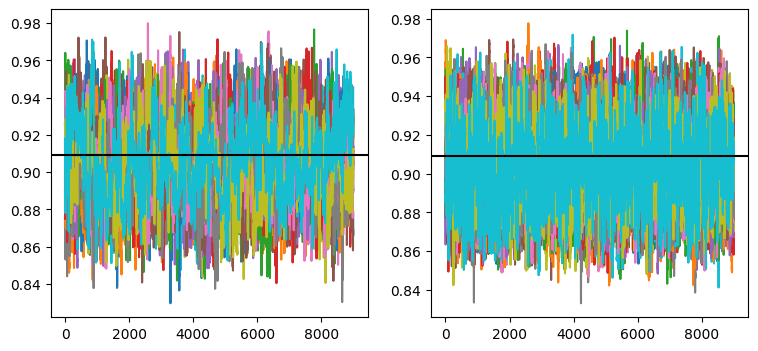

In [32]:
idim = 4 
nwalkers = 20 

plt.figure(figsize=(9, 4))
plt.subplot(121)
for i in range(nwalkers):
# for i in range(0, 1):
    plt.plot(cm[1000:, i, idim])
plt.axhline(truep[idim], color='k')

plt.subplot(122)
for i in range(nwalkers):
# for i in range(0, 1):
    plt.plot(cz[1000:, i, idim])
plt.axhline(truep[idim], color='k')




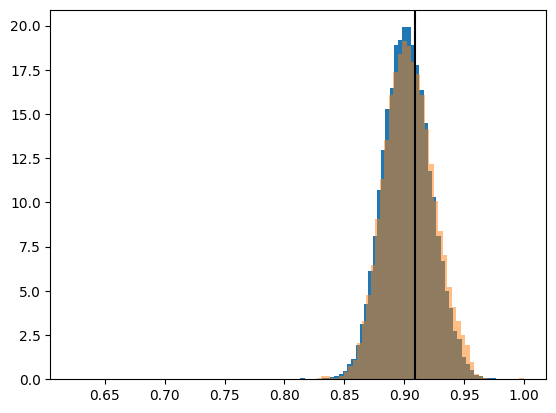

In [39]:
idim = 4
plt.hist(cm[..., idim].flatten(), bins=100, density=True);
plt.hist(cz[..., idim].flatten(), bins=100, density=True, alpha=0.5);
plt.axvline(truep[idim], color='k')

In [40]:
cm.shape

(10000, 20, 6)

In [62]:
cm.shape, cz.shape

((10000, 20, 6), (10000, 20, 6))

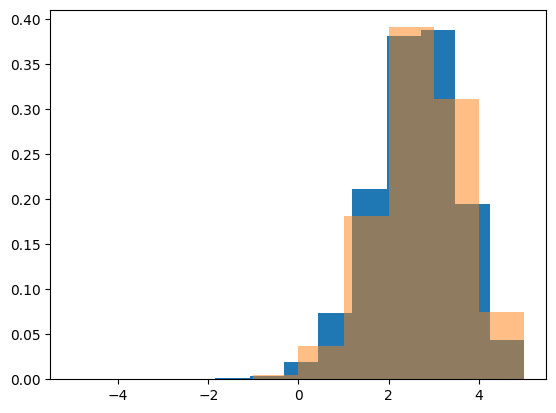

In [61]:
plt.hist(cm[..., 5].flatten(), density=True)
plt.hist(cz[..., 5].flatten(), alpha=0.5, density=True);

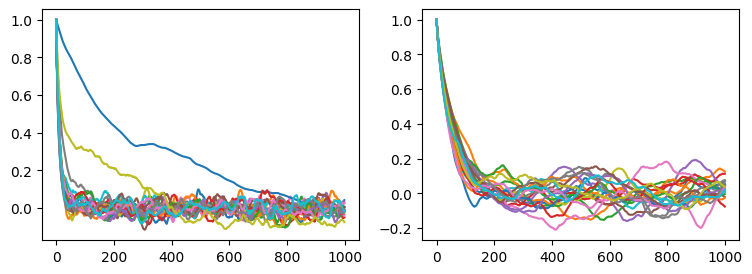

In [56]:
idim = 5

plt.figure(figsize=(9, 3))
plt.subplot(121)
for i in range(nwalkers):
    plot(az.autocorr(cz[:, i, idim])[:1000])
plt.subplot(122)
for i in range(nwalkers):
    plot(az.autocorr(cm[:, i, idim])[:1000])

In [123]:
sum(list(map(az.ess, cm[..., 0].T)))

1702.3193533592512

In [113]:
idim = 0 
for i in range(nwalkers):
    print(az.ess(cm[:, i, 0]))

75.96535457785372
97.28581895252506
98.10279539636097
72.72150798620765
71.0277063737616
84.66674992468462
74.82575589111235
86.4833281661455
125.98161398964528
93.8591329116604
89.14685861159131
84.60515496667
112.9987642714466
49.61994485621496
109.85709477478993
92.01781221864239
67.61220736039456
83.38873507058116
84.66100321379392
47.4920138451693


In [132]:
idim = 0 
for i in range(nwalkers):
    print(i, az.ess(cz[:, i, 0]))

0 493.6778334094799
1 439.6904438857172
2 245.6174598344546
3 463.57380443379316
4 454.5704205845396
5 531.2164025685623
6 430.34542021658
7 316.8576877691468
8 523.763661164728
9 513.6615597731724
10 6.255633709347533
11 297.35023829363735
12 414.6054003727527
13 454.60185706156824
14 367.00437989942867
15 388.52154666983245
16 394.57761842258316
17 403.9107843663903
18 23.877241298972567
19 435.37361620230735


In [134]:
cz2 = []
for i in range(nwalkers):
    if az.ess(cz[:, i, 0]) > 100: 
        cz2.append(cz[:, i])
cz2 = np.stack(cz2, axis=1)


In [136]:
cm.mean(axis=(0, 1)), cz2.mean(axis=(0, 1)), cz.mean(axis=(0, 1))

(array([0.29954249, 0.06186063, 0.65051042, 0.91663628, 0.9023993 ,
        2.61136753]),
 array([0.29922687, 0.06184564, 0.64857349, 0.92073024, 0.90342029,
        2.65131865]),
 array([0.29240956, 0.06022389, 0.66019782, 0.93259345, 0.90439176,
        2.68302111]))

In [137]:
cm.std(axis=(0, 1)), cz2.std(axis=(0, 1)), cz.std(axis=(0, 1))

(array([0.01513991, 0.00666301, 0.06753981, 0.07599822, 0.02020339,
        0.9510374 ]),
 array([0.0163065 , 0.00659748, 0.06811516, 0.07940173, 0.02008145,
        0.93989579]),
 array([0.03930282, 0.00943858, 0.08606244, 0.09395873, 0.02114201,
        0.95787352]))

In [198]:
lh = 2
nwalkers = 20 
truep = params[lh]
chains = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/PT/emcee_chains/LH{lh}_kmax0.15.npy')

['70.90', '33.43', '47.92', '67.29', '58.99', '48.97', '91.32', '75.47', '50.55', '43.97', '83.24', '64.63', '60.76', '48.47', '56.58', '59.19', '98.28', '85.33', '58.68', '29.85']
1233.826651412712


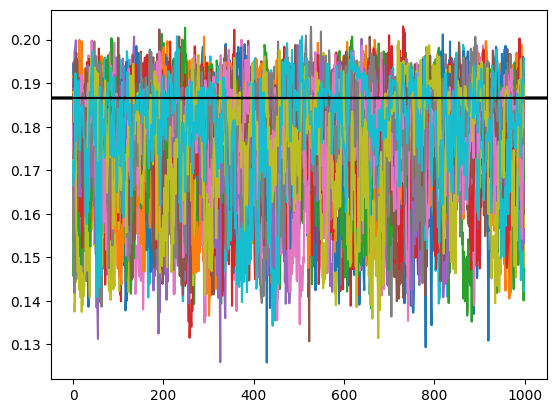

In [199]:
idim = 0
print(list(['%0.2f'%i for i in map(az.ess, chains[..., idim].T)]))
print(sum(list([i for i in map(az.ess, chains[..., idim].T)])))
for j in range(nwalkers):
    plt.plot(chains[:, j, idim])
    plt.axhline(truep[idim], color='k')
    

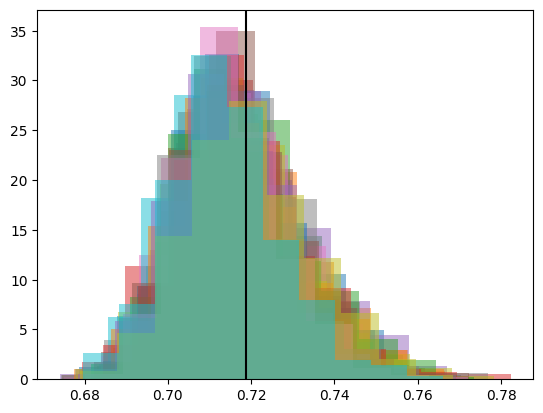

In [202]:
idim = 4

for j in range(nwalkers):
    plt.hist(chains[:, j, idim], density=True, alpha=0.5)
plt.axvline(truep[idim], color='k')
    

In [190]:
for idim in range(6):
    print(chains.std(axis=0)[:, idim].std()/chains.std(axis=(0, 1))[idim])
print()
for idim in range(6):
    print(chains.mean(axis=0)[:, idim].std()/chains.mean(axis=(0, 1))[idim])

0.03912898757223262
0.05291146222428437
0.04373263117128951
0.03881755814214594
0.04546143412912828
0.054067843790955195

0.0037296160821010996
0.007543662860774756
0.009263223303092661
0.007937044942756127
0.0032501295160023615
0.066781498292419


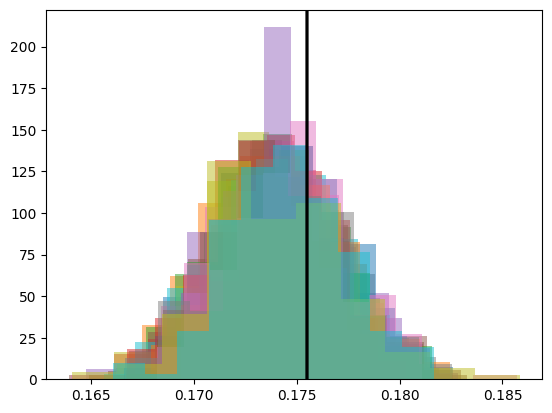

In [159]:
idim = 0
for j in range(nwalkers):
    plt.hist(chains[:, j, idim], density=True, alpha=0.5)
    plt.axvline(truep[idim], color='k')
    